# Deep Learning with PyTorch : Build a Generative Adversarial Network

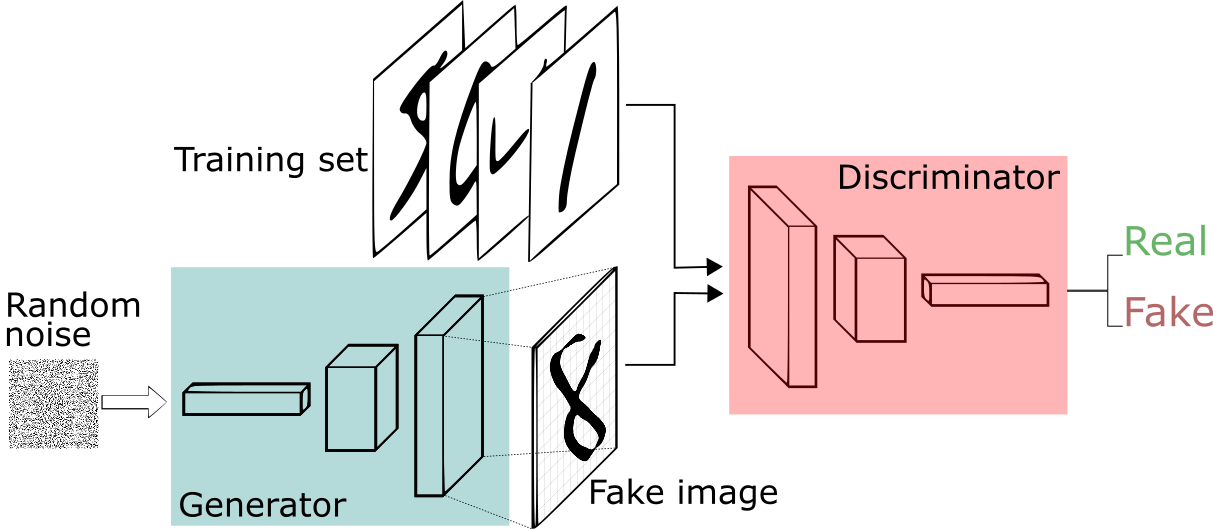

In [1]:
import torch
torch.manual_seed(42)
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

/scratch/s.1915438/env/modulus/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Configurations

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
batch_size = 128 # Batch size during training
noise_dim = 64 # Shape of the random noise vector that we will use to generate the fake images

# Optimiser params
lr = 0.0002
beta_1 = 0.5
beta_2 = 0.99

# Training params
epochs = 5000

# Load MNIST Dataset

In [3]:
from torchvision import datasets,transforms as T

In [4]:
# various transforms to be applied on the images
train_augs = T.Compose([T.RandomRotation((-20,+20)),
                        T.ToTensor(), # (h,w,c) -> (c,h,w)
                        ])

In [5]:
# Download the MNIST dataset and apply the transforms
trainset = datasets.MNIST('MNIST/', download=True, train=True, transform=train_augs)

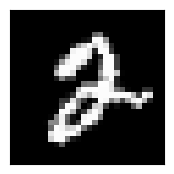

In [6]:
# Checking the image and label
image, label = trainset[5]
plt.figure(figsize=(2,2))
plt.imshow(image.squeeze(), cmap='gray')
plt.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

In [7]:
print(f"Total images: {len(trainset)}")

Total images: 60000


# Load Dataset Into Batches

In [8]:
from torch.utils.data import DataLoader # to create batches
from torchvision.utils import make_grid # to create a grid of images

In [9]:
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True) # load the data in batches

In [10]:
print(f"Total no. of batches: {len(trainloader)}")

Total no. of batches: 469


In [11]:
dataiter = iter(trainloader)
images,_ = next(dataiter) # get the next batch of images

print(images.shape) # number of images in a batch, no. of channels, height, width

torch.Size([128, 1, 28, 28])


In [12]:
# 'show_tensor_images' : function is used to plot some of images from the batch

def show_tensor_images(tensor_img, num_images = 16, size=(1, 28, 28)):
    unflat_img = tensor_img.detach().cpu()
    img_grid = make_grid(unflat_img[:num_images], nrow=4)
    plt.imshow(img_grid.permute(1, 2, 0).squeeze())
    plt.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
    plt.show()

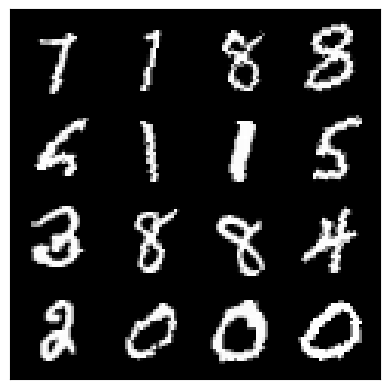

In [13]:
show_tensor_images(images)

# Create Discriminator Network

In [14]:
#In case if torch summary is not installed

from torch import nn
from torchsummary import summary

In [15]:
'''

Network : Discriminator (reference diagram)

bs-> batch_size

input : (bs, 1, 28, 28)
      |                                                                                               ---- SUMMARY ----
      V
Conv2d( in_channels = 1, out_channels = 16, kernel_size = (3,3), stride = 2)                           #(bs, 16, 13, 13)
BatchNorm2d()                                                                                          #(bs, 16, 13, 13)
LeakyReLU()                                                                                            #(bs, 16, 13, 13)
      |
      V
Conv2d( in_channels = 16, out_channels = 32, kernel_size = (5,5), stride = 2)                          #(bs, 32, 5, 5)
BatchNorm2d()                                                                                          #(bs, 32, 5, 5)
LeakyReLU()                                                                                            #(bs, 32, 5, 5)
      |
      V
Conv2d( in_channels = 32, out_channels = 64, kernel_size = (5,5), stride = 2)                          #(bs, 64, 1, 1)
BatchNorm2d()                                                                                          #(bs, 64, 1, 1)
LeakyReLU()                                                                                            #(bs, 64, 1, 1)
      |
      V
Flatten()                                                                                              #(bs, 64)
Linear(in_features = 64, out_features = 1)                                                             #(bs, 1)

'''

'\n\nNetwork : Discriminator (reference diagram)\n\nbs-> batch_size\n\ninput : (bs, 1, 28, 28)\n      |                                                                                               ---- SUMMARY ----\n      V\nConv2d( in_channels = 1, out_channels = 16, kernel_size = (3,3), stride = 2)                           #(bs, 16, 13, 13)\nBatchNorm2d()                                                                                          #(bs, 16, 13, 13)\nLeakyReLU()                                                                                            #(bs, 16, 13, 13)\n      |\n      V\nConv2d( in_channels = 16, out_channels = 32, kernel_size = (5,5), stride = 2)                          #(bs, 32, 5, 5)\nBatchNorm2d()                                                                                          #(bs, 32, 5, 5)\nLeakyReLU()                                                                                            #(bs, 32, 5, 5)\n      |\n      V\nConv2d( in_c

In [16]:
def get_disc_block(in_channels, out_channels, kernel_size, stride):
    """Discriminator block"""
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, stride),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(0.2))


In [17]:
# Now we can create a discriminator network for the training images
class Discriminator(nn.Module):
    """Discriminator Network"""
    def __init__(self):
        super().__init__()

        # Declaring variables we need for the forward pass
        self.block_1 = get_disc_block(in_channels = 1, out_channels = 16, kernel_size = (3,3), stride = 2)
        self.block_2 = get_disc_block(in_channels = 16, out_channels = 32, kernel_size = (5,5), stride = 2)
        self.block_3 = get_disc_block(in_channels = 32, out_channels = 64, kernel_size = (5,5), stride = 2)

        self.flatten = nn.Flatten()
        self.linear = nn.Linear(in_features = 64, out_features = 1)

    def forward(self, images):
        """Forward pass"""

        # Convolution layers
        x1 = self.block_1(images)
        x2 = self.block_2(x1)
        x3 = self.block_3(x2)

        # Flatten and pass it through the linear layer
        x4 = self.flatten(x3)
        x5 = self.linear(x4)
        
        return x5

In [18]:
D = Discriminator().to(device)
summary(D, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 13, 13]             160
       BatchNorm2d-2           [-1, 16, 13, 13]              32
         LeakyReLU-3           [-1, 16, 13, 13]               0
            Conv2d-4             [-1, 32, 5, 5]          12,832
       BatchNorm2d-5             [-1, 32, 5, 5]              64
         LeakyReLU-6             [-1, 32, 5, 5]               0
            Conv2d-7             [-1, 64, 1, 1]          51,264
       BatchNorm2d-8             [-1, 64, 1, 1]             128
         LeakyReLU-9             [-1, 64, 1, 1]               0
          Flatten-10                   [-1, 64]               0
           Linear-11                    [-1, 1]              65
Total params: 64,545
Trainable params: 64,545
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

# Create Generator Network

In [19]:
'''

Network : Generator
Generator network takes a random noise vector and generates an image (fake) from it.

noise_dim = 64 (declared earlier)
input : (bs,noise_dim) (we need to reshape here because conv layers take 4D input)

      |
      | Reshape
      V

input : (bs, channel, height, width) -> (bs, noise_dim , 1 , 1)
      |                                                                                               ---- SUMMARY ----
      V
ConvTranspose2d( in_channels = noise_dim, out_channels = 256, kernel_size = (3,3), stride = 2)             #(bs, 256, 3, 3)
BatchNorm2d()                                                                                          #(bs, 256, 3, 3)
ReLU()                                                                                                 #(bs, 256, 3, 3)
      |
      V
ConvTranspose2d( in_channels = 256, out_channels = 128, kernel_size = (4,4), stride = 1)               #(bs, 128, 6, 6)
BatchNorm2d()                                                                                          #(bs, 128, 6, 6)
ReLU()                                                                                                 #(bs, 128, 6, 6)
      |
      V
ConvTranspose2d( in_channels = 128, out_channels = 64, kernel_size = (3,3), stride = 2)                #(bs, 64, 13, 13)
BatchNorm2d()                                                                                          #(bs, 64, 13, 13)
ReLU()                                                                                                 #(bs, 64, 13, 13)
      |
      V
ConvTranspose2d( in_channels = 64, out_channels = 1, kernel_size = (4,4), stride = 2)                  #(bs, 1, 28, 28)
Tanh()                                                                                                 #(bs, 1, 28, 28)

'''

'\n\nNetwork : Generator\nGenerator network takes a random noise vector and generates an image (fake) from it.\n\nnoise_dim = 64 (declared earlier)\ninput : (bs,noise_dim) (we need to reshape here because conv layers take 4D input)\n\n      |\n      | Reshape\n      V\n\ninput : (bs, channel, height, width) -> (bs, noise_dim , 1 , 1)\n      |                                                                                               ---- SUMMARY ----\n      V\nConvTranspose2d( in_channels = noise_dim, out_channels = 256, kernel_size = (3,3), stride = 2)             #(bs, 256, 3, 3)\nBatchNorm2d()                                                                                          #(bs, 256, 3, 3)\nReLU()                                                                                                 #(bs, 256, 3, 3)\n      |\n      V\nConvTranspose2d( in_channels = 256, out_channels = 128, kernel_size = (4,4), stride = 1)               #(bs, 128, 6, 6)\nBatchNorm2d()              

In [20]:
def get_gen_block(in_channels, out_channels, kernel_size, stride, final_block = False):
    """Generator block
    All layers are same except the last layer which uses tanh activation function and no batch norm, so we will use an if condition
    """
    if final_block:
        return nn.Sequential(
        nn.ConvTranspose2d(in_channels , out_channels , kernel_size , stride),
        nn.Tanh(),
    )
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels , out_channels , kernel_size , stride),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
    )

In [21]:
# Class to generate the fake images
class Generator(nn.Module):
    def __init__(self, noise_dim):
        super().__init__()

        self.noise_dim = noise_dim
        # Declaring variables we need for the forward pass
        self.block_1 = get_gen_block(in_channels = noise_dim, out_channels = 256, kernel_size = (3,3), stride = 2)
        self.block_2 = get_gen_block(in_channels = 256, out_channels = 128, kernel_size = (4,4), stride = 1)
        self.block_3 = get_gen_block(in_channels = 128, out_channels = 64, kernel_size = (3,3), stride = 2)
        self.block_4 = get_gen_block(in_channels = 64, out_channels = 1, kernel_size = (4,4), stride = 2, final_block = True)

    def forward(self, random_noise):
        """forward pass"""
        # random_noise -> (bs,noise_dim) -> (bs, noise_dim , 1 , 1)
        x = random_noise.view(-1, self.noise_dim, 1, 1) 
        # Convolutional layers
        
        x1 = self.block_1(x)
        x2 = self.block_2(x1)
        x3 = self.block_3(x2)
        x4 = self.block_4(x3)

        return x4

In [22]:
G = Generator(noise_dim).to(device)
summary(G, input_size=(1, noise_dim))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 3, 3]         147,712
       BatchNorm2d-2            [-1, 256, 3, 3]             512
              ReLU-3            [-1, 256, 3, 3]               0
   ConvTranspose2d-4            [-1, 128, 6, 6]         524,416
       BatchNorm2d-5            [-1, 128, 6, 6]             256
              ReLU-6            [-1, 128, 6, 6]               0
   ConvTranspose2d-7           [-1, 64, 13, 13]          73,792
       BatchNorm2d-8           [-1, 64, 13, 13]             128
              ReLU-9           [-1, 64, 13, 13]               0
  ConvTranspose2d-10            [-1, 1, 28, 28]           1,025
             Tanh-11            [-1, 1, 28, 28]               0
Total params: 747,841
Trainable params: 747,841
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [23]:
# Replace Random initialized weights to Normal weights

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight, 0.0, 0.02) # mean = 0.0, std = 0.02
    if isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, 0.0, 0.02) # mean = 0.0, std = 0.02
        nn.init.constant_(m.bias, 0)

In [24]:
D = D.apply(weights_init)
G = G.apply(weights_init)

# Create Loss Function and Load Optimizer
* real loss function
* fake loss function

In [25]:
def real_loss(disc_pred):
    criterion = nn.BCEWithLogitsLoss()
    ground_truth = torch.ones_like(disc_pred) # all ones
    loss = criterion(disc_pred, ground_truth)
    return loss

def fake_loss(disc_pred):
    criterion = nn.BCEWithLogitsLoss()
    ground_truth = torch.zeros_like(disc_pred) # all zeros
    loss = criterion(disc_pred, ground_truth)
    return loss

In [26]:
# discriminator and generator optimizers
D_opt = torch.optim.Adam(D.parameters(), lr=lr, betas=(beta_1, beta_2)) #defined in the first cell
G_opt = torch.optim.Adam(G.parameters(), lr=lr, betas=(beta_1, beta_2)) #defined in the first cell

# Training Loop
Now we have all the recipes to train the neural network system

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 1/50 | D loss: 0.6856 | G loss: 0.6893


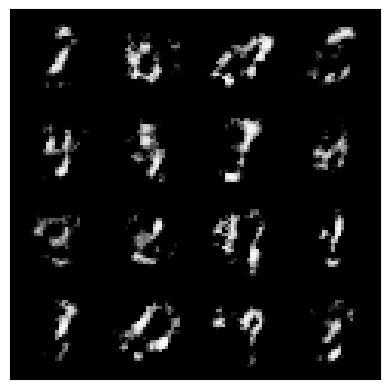

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 2/50 | D loss: 0.6752 | G loss: 0.7151


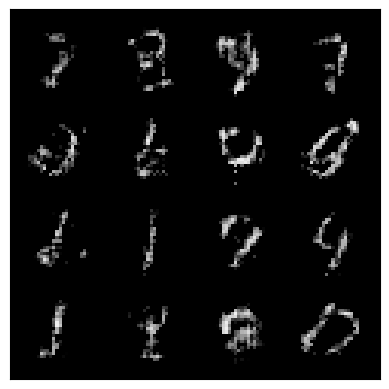

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 3/50 | D loss: 0.6093 | G loss: 0.7914


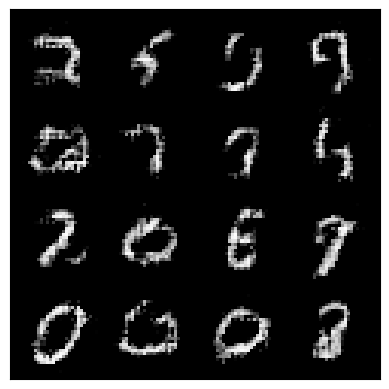

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 4/50 | D loss: 0.5485 | G loss: 0.8840


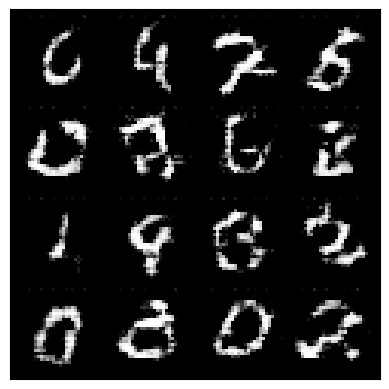

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 5/50 | D loss: 0.5231 | G loss: 0.9469


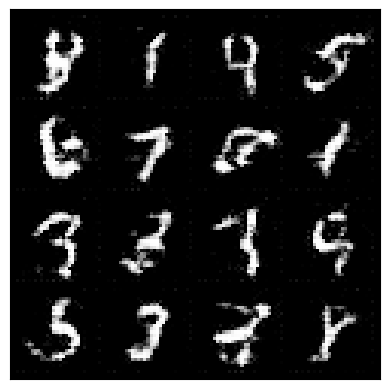

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 6/50 | D loss: 0.5021 | G loss: 1.0025


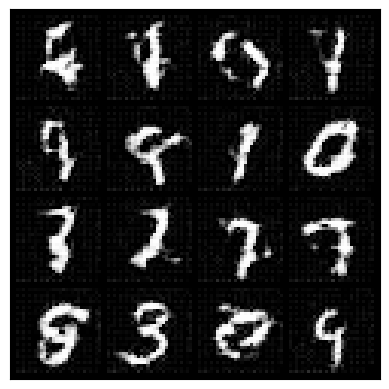

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 7/50 | D loss: 0.4628 | G loss: 1.1114


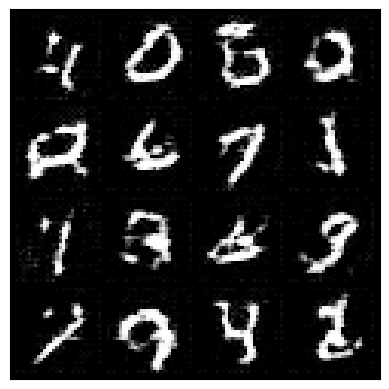

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 8/50 | D loss: 0.4557 | G loss: 1.1641


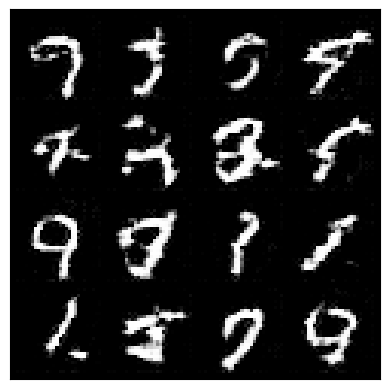

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 9/50 | D loss: 0.4751 | G loss: 1.1456


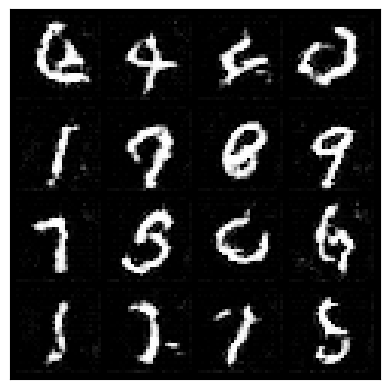

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 10/50 | D loss: 0.4888 | G loss: 1.1325


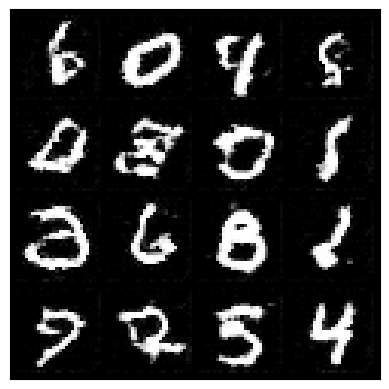

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 11/50 | D loss: 0.5057 | G loss: 1.1041


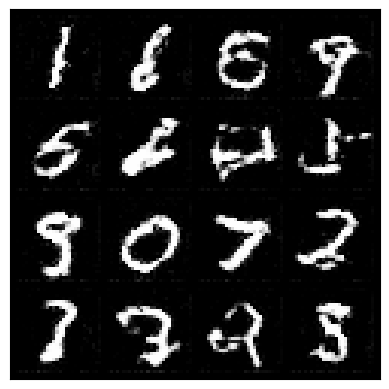

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 12/50 | D loss: 0.5241 | G loss: 1.0842


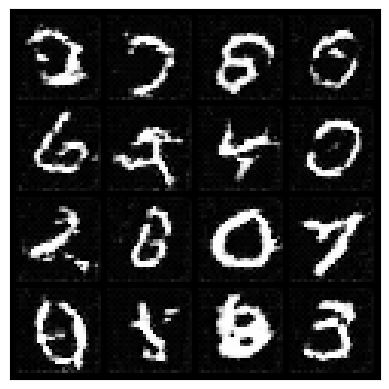

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 13/50 | D loss: 0.5416 | G loss: 1.0484


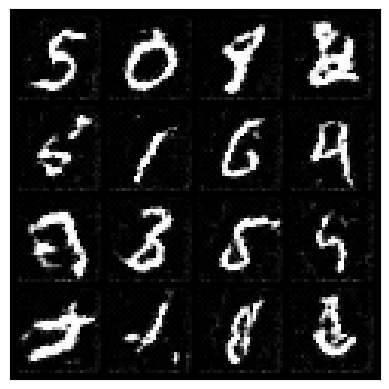

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 14/50 | D loss: 0.5541 | G loss: 1.0253


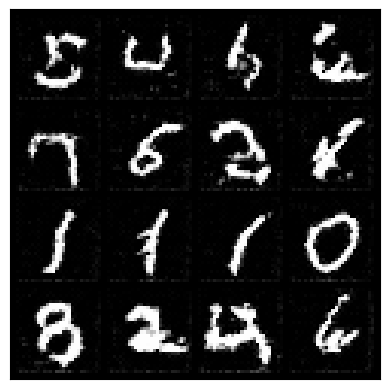

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 15/50 | D loss: 0.5602 | G loss: 1.0191


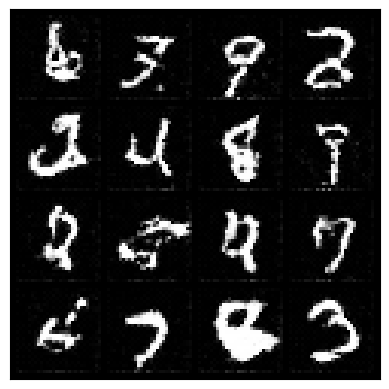

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 16/50 | D loss: 0.5707 | G loss: 1.0019


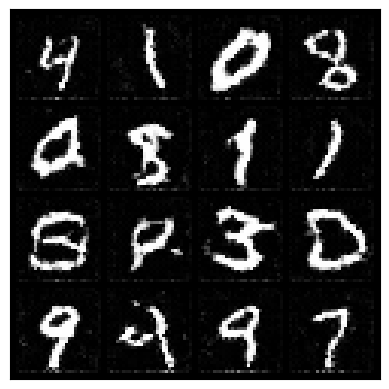

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 17/50 | D loss: 0.5744 | G loss: 0.9895


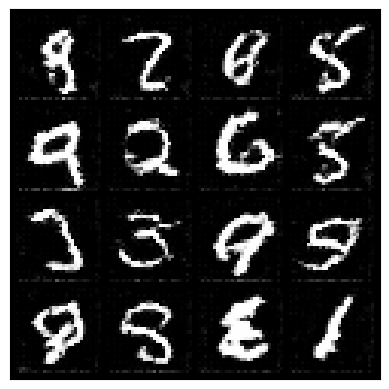

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 18/50 | D loss: 0.5796 | G loss: 0.9819


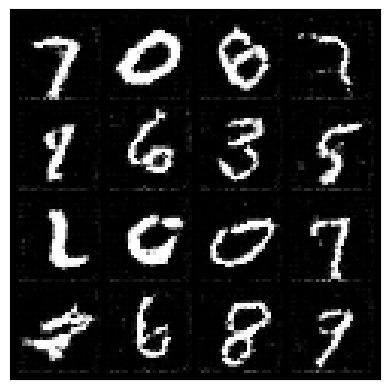

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 19/50 | D loss: 0.5872 | G loss: 0.9751


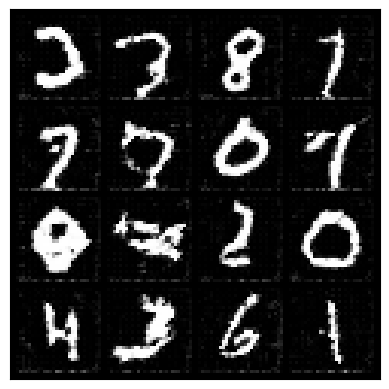

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 20/50 | D loss: 0.5883 | G loss: 0.9613


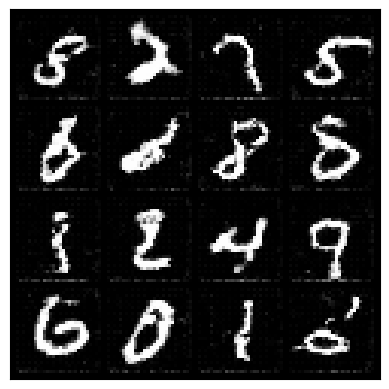

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 21/50 | D loss: 0.5921 | G loss: 0.9575


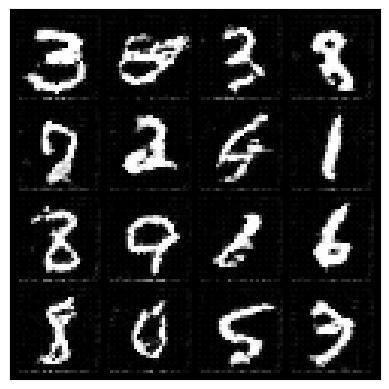

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 22/50 | D loss: 0.5954 | G loss: 0.9515


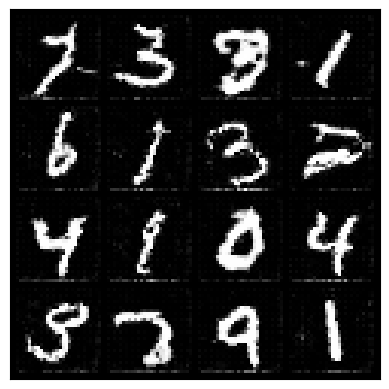

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 23/50 | D loss: 0.5954 | G loss: 0.9498


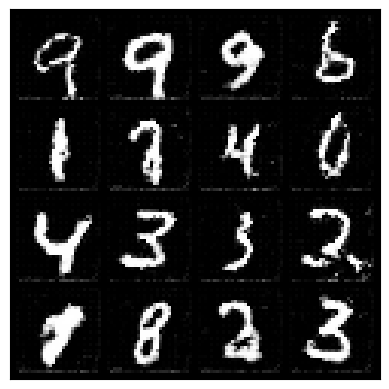

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 24/50 | D loss: 0.5976 | G loss: 0.9443


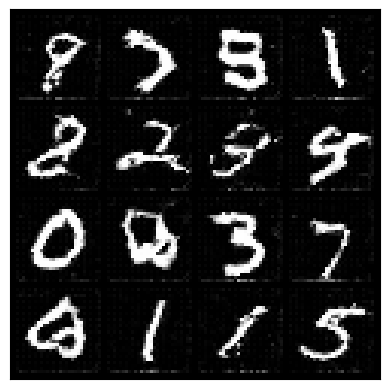

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 25/50 | D loss: 0.6027 | G loss: 0.9394


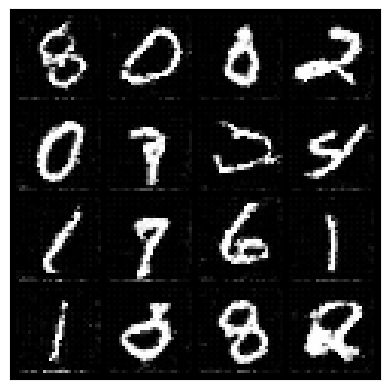

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 26/50 | D loss: 0.6031 | G loss: 0.9358


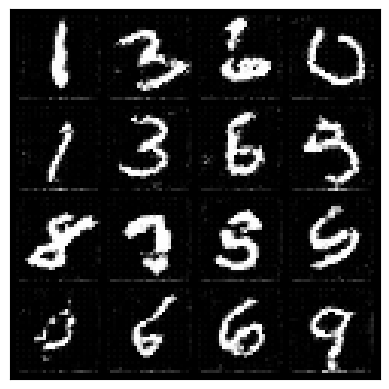

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 27/50 | D loss: 0.6032 | G loss: 0.9408


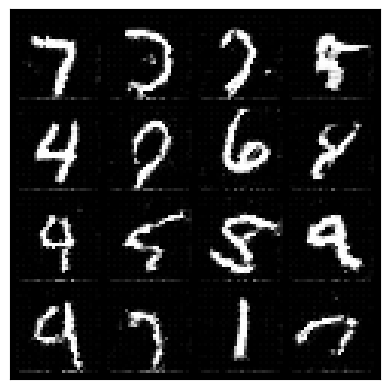

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 28/50 | D loss: 0.6030 | G loss: 0.9379


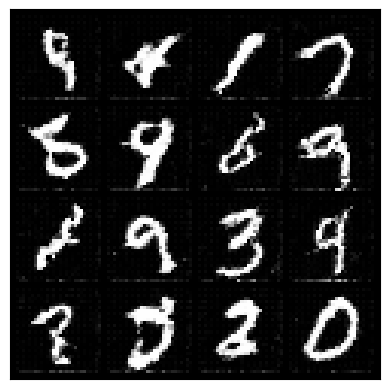

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 29/50 | D loss: 0.6029 | G loss: 0.9363


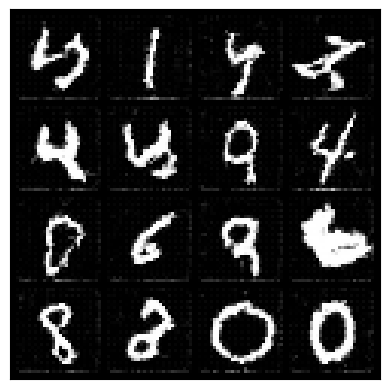

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 30/50 | D loss: 0.6048 | G loss: 0.9322


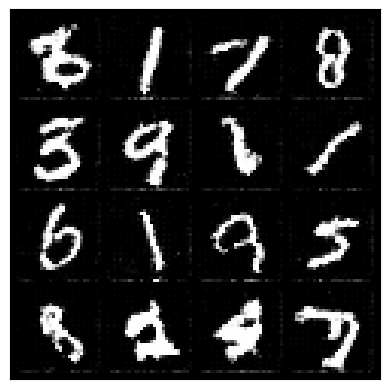

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 31/50 | D loss: 0.6024 | G loss: 0.9387


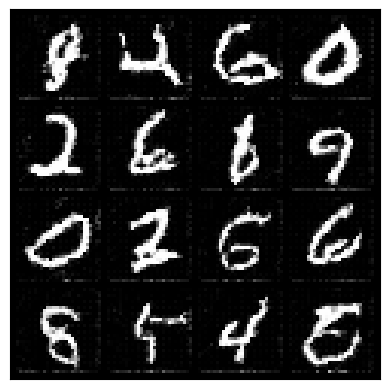

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 32/50 | D loss: 0.6012 | G loss: 0.9363


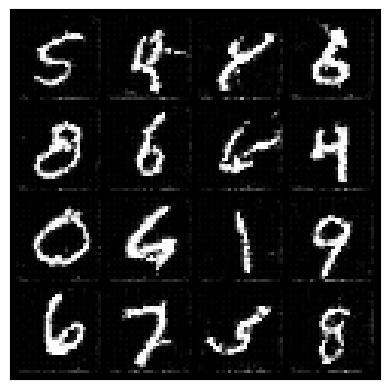

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 33/50 | D loss: 0.6007 | G loss: 0.9439


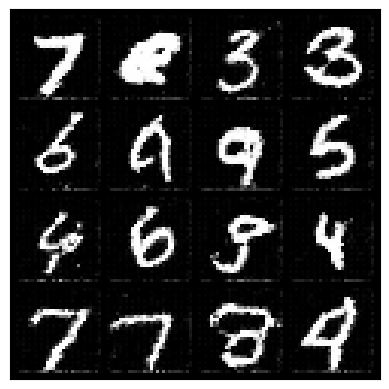

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 34/50 | D loss: 0.6007 | G loss: 0.9453


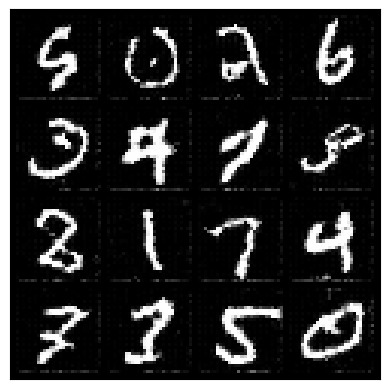

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 35/50 | D loss: 0.5980 | G loss: 0.9490


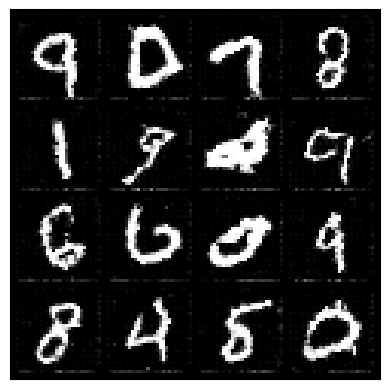

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 36/50 | D loss: 0.5988 | G loss: 0.9490


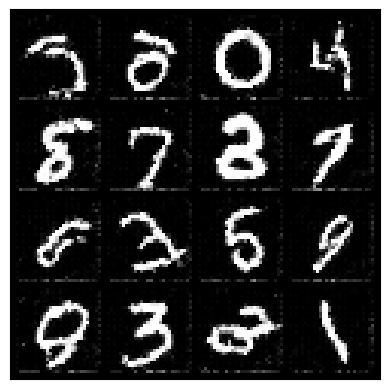

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 37/50 | D loss: 0.6002 | G loss: 0.9518


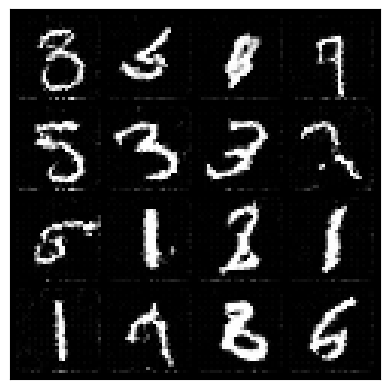

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 38/50 | D loss: 0.6000 | G loss: 0.9465


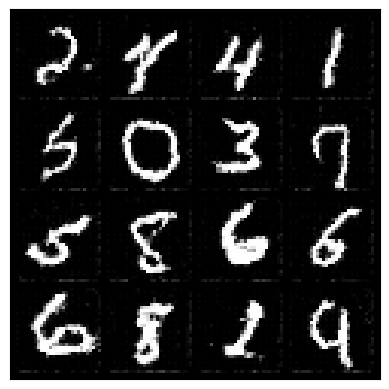

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 39/50 | D loss: 0.6010 | G loss: 0.9502


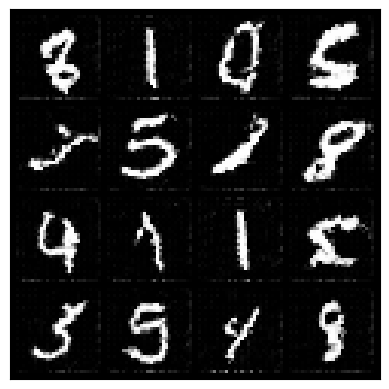

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 40/50 | D loss: 0.5986 | G loss: 0.9530


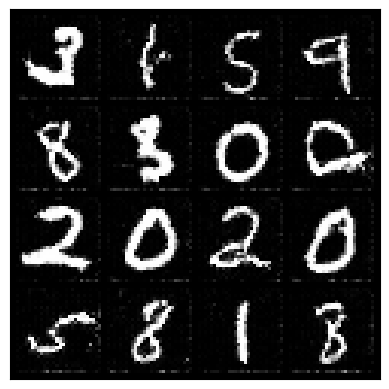

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 41/50 | D loss: 0.6017 | G loss: 0.9521


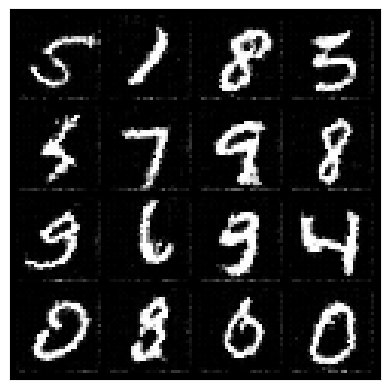

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 42/50 | D loss: 0.6046 | G loss: 0.9475


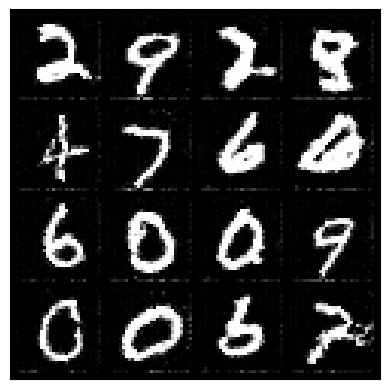

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 43/50 | D loss: 0.6009 | G loss: 0.9478


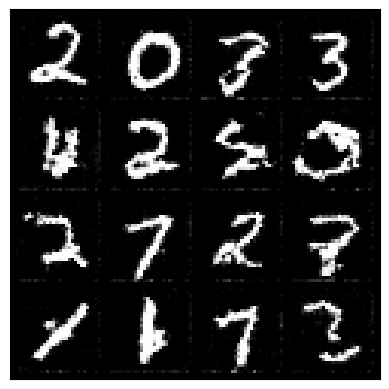

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 44/50 | D loss: 0.6011 | G loss: 0.9525


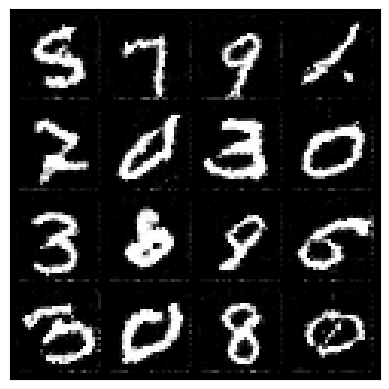

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 45/50 | D loss: 0.5999 | G loss: 0.9560


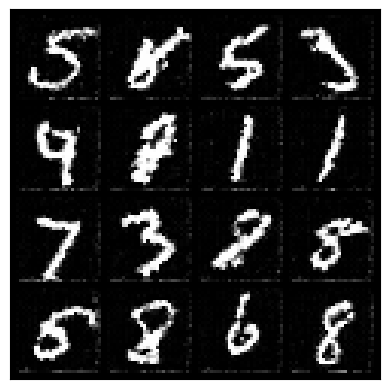

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 46/50 | D loss: 0.6001 | G loss: 0.9559


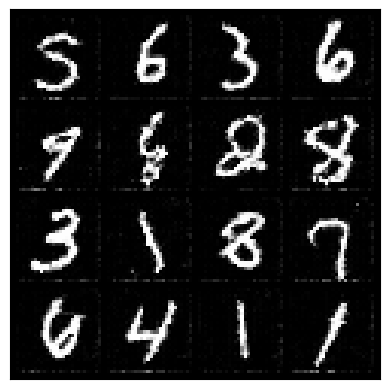

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 47/50 | D loss: 0.5977 | G loss: 0.9566


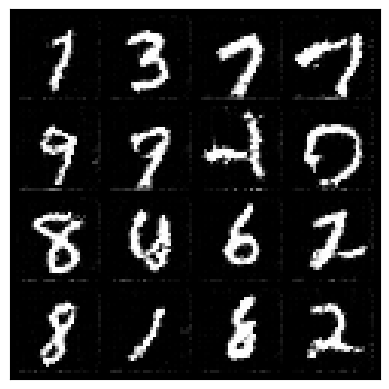

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 48/50 | D loss: 0.5962 | G loss: 0.9656


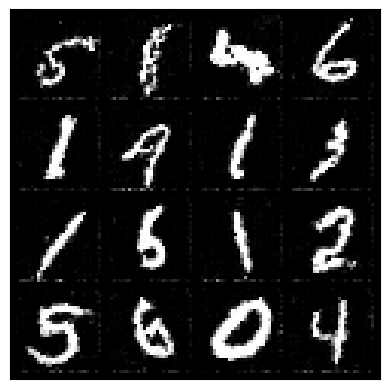

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 49/50 | D loss: 0.5955 | G loss: 0.9711


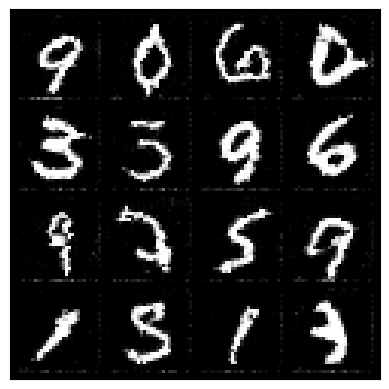

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 50/50 | D loss: 0.5934 | G loss: 0.9743


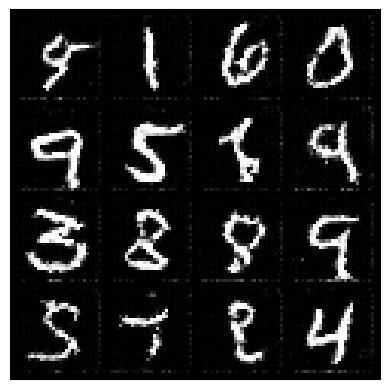

In [27]:
total_d_loss_array = data_loss_array = np.zeros(epochs)
total_g_loss_array = data_loss_array = np.zeros(epochs)

for i in range(epochs):
    # initialize loss variables before each batch
    total_d_loss = 0.0
    total_g_loss = 0.0

    # batch training
    for real_img, _ in (trainloader):
        real_img = real_img.to(device) # move the images to the CUDA device
        noise = torch.randn(batch_size, noise_dim).to(device) # generate random noise for the generator

        ### Train the discriminator
        D_opt.zero_grad() # avoid gradient accumulation

        # see the first image of the notebook
        fake_img = G(noise) # generate fake images from the noise
        D_pred = D(fake_img) # pass the fake images to the discriminator

        D_fake_loss = fake_loss(D_pred) # pass the fake images to the discriminator

        D_pred = D(real_img)
        D_real_loss = real_loss(D_pred) # pass the real images to the discriminator

        D_loss = (D_fake_loss + D_real_loss)/2 # average loss
        total_d_loss += D_loss.item() # accumulate the discriminator loss

        D_loss.backward() # gradients for discriminator

        D_opt.step() # update discriminator weights

        ### Train the generator
        G_opt.zero_grad() # avoid gradient accumulation
        noise = torch.randn(batch_size, noise_dim).to(device) # generate random noise for the generator

        fake_img = G(noise) # generate fake images from the noise
        D_pred = D(fake_img) # pass the fake images to the discriminator

        G_loss = real_loss(D_pred) # we want the generator to create real images
        total_g_loss += G_loss.item() # accumulate the generator loss

        G_loss.backward() # gradients for generator
        G_opt.step() # update generator weights
    
    avg_d_loss = total_d_loss/len(trainloader) # average discriminator loss over all batches
    avg_g_loss = total_g_loss/len(trainloader) # average generator loss over all batches

    total_d_loss_array[i] = total_d_loss
    total_g_loss_array[i] = total_g_loss

    print(f"Epoch: {i+1}/{epochs} | D loss: {avg_d_loss:.4f} | G loss: {avg_g_loss:.4f}")
    #show_tensor_images(fake_img)

In [ ]:
plt.figure(dpi=150)
indices = np.arange(0,epochs,1) 
iter_array = np.arange(0,epochs)

plt.plot(iter_array[indices],total_d_loss_array[indices], linewidth=1)
plt.plot(iter_array[indices],total_g_loss_array[indices], linewidth=1)
plt.legend(['D Loss', 'G Loss'])
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.savefig('Loss_curve.jpg', dpi = 500,bbox_inches='tight',transparent=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


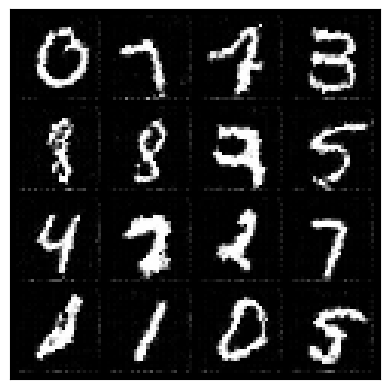

In [28]:
# Run after training is completed.
# Now you can use Generator Network to generate handwritten images

noise = torch.randn(batch_size, noise_dim, device = device)
generated_image = G(noise)

show_tensor_images(generated_image)

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya